# Part 1. Create base grid with H3

### Import necessary modules

In [2]:
### Activate geospatial_env first

# Numeric
import numpy as np
import pandas as pd
import math

# System
import os
import shutil
from IPython.display import display, Markdown, HTML, FileLink, FileLinks

# Spatial
import geopandas as gpd
import json
import pyproj
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.wkt import dumps, loads
from shapely.ops import nearest_points
from pyproj import CRS
import ogr, gdal, osr
#import fiona


# Mapping / Plotting
from functools import reduce
#import datapane as dp 
#!datapane login --token="9bde41bfbc4ad14119e32086f9f06d2e5db1d5b8"
import folium
from folium.features import GeoJsonTooltip
from folium.plugins import BeautifyIcon
from folium.plugins import HeatMap
import branca.colormap as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

%matplotlib inline

In [3]:
#import geopandas as gpd   # Note that you require geopandas version >= 0.7 that incluse clip see here for installation (https://gis.stackexchange.com/questions/360127/geopandas-0-6-1-installed-instead-of-0-7-0-in-conda-windows-10#)
import os
import fiona
import ipywidgets as widgets
from IPython.display import display
from rasterstats import zonal_stats
import rasterio
from geojson import Feature, Point, FeatureCollection
import rasterio.fill
from shapely.geometry import shape, mapping
import json
#from earthpy import clip    clip has been deprecated to geopandas
#import earthpy.spatial as es
import numpy as np
import tkinter as tk
from tkinter import filedialog, messagebox
import gdal
import datetime
import warnings
import pandas as pd
import scipy.spatial
warnings.filterwarnings('ignore')

#import contextily as ctx
import h3 as h3
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon

root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)

pd.options.display.float_format = '{:,.4f}'.format

In [4]:
from utils import processing_raster, finalizing_rasters

### Define directories and dataset names

In [5]:
### Define directories and dataset names
ROOT_DIR = os.path.abspath(os.curdir)
in_path = ROOT_DIR
out_path = ROOT_DIR + "/Outputs"

## admininstrative boundary
admin_path = in_path + "\\"+ 'admin'
admin_name = "Copperbelt.gpkg"
adm_col_name = "ADM1_NAME"          ## Provide the name of the column you want to use to clip the hexagons e.g., "NAME" or "ADM1_NAME"

In [6]:
## Coordinate and projection systems
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
crs_proj = CRS("EPSG:32736")    # Projection system for the selected country -- see http://epsg.io/ for more info

### Import layers to be used

In [7]:
## admininstrative boundary
admin_gdf = gpd.read_file(admin_path + "/" + admin_name)

### H3 - Hegagon - grid

In [8]:
# Make a copy of the original dataframe (as it might require some changes)
admin_gdf_copy_2 = admin_gdf.buffer(1.245)     ## this is ~15km --> 0.83*1.5

In [9]:
## No of multipolygons in the geometry
#check_geom_type = admin_gdf_copy.geometry.apply(lambda x: list(x))[0]

#len(check_geom_type)


However, if polygons are not close this will not work. Thus, the following process (which I do only for one of them) needs to be done for each polygon separately -- unless you write some code to do this automatically! :)

In [10]:
#polygon = check_geom_type[0]
#polygon

In [11]:
#combined = [unary_union(polygon)]
#admin_gdf_copy.geometry = combined

In [12]:
# Convert this to geojson
gj = gpd.GeoSeries([admin_gdf_copy_2.geometry[0]]).__geo_interface__
geoJson = gj['features'][0]['geometry']

In [13]:
size = 7 ## resolution info here https://h3geo.org/docs/core-library/restable
hexagons = pd.DataFrame(h3.polyfill(geoJson, size), columns=['hexagons'])
hexagons.head()

,hexagons
0,875533986ffffff
1,873996928ffffff
2,875532b20ffffff
3,875535704ffffff
4,8755340d5ffffff


In [14]:
hexagons['geometry'] = hexagons.hexagons.apply(lambda hex: Polygon(h3.h3_to_geo_boundary(hex)))
hexagons['centeroid'] = hexagons.hexagons.apply(lambda hex: h3.h3_to_geo(hex))

crs = {'init': 'epsg:4326'}

hexagons = gpd.GeoDataFrame(hexagons, crs=crs, geometry=hexagons.geometry)
hexagons['lon'] = hexagons['centeroid'].apply(lambda x: x[0])
hexagons['lat'] = hexagons['centeroid'].apply(lambda x: x[1])

hexagons = hexagons.drop(['centeroid'], axis=1)

display(hexagons.head())

,hexagons,geometry,lon,lat
0,875533986ffffff,"POLYGON ((26.16085 -13.19988, 26.15078 -13.209...",26.1482,-13.1955
1,873996928ffffff,"POLYGON ((29.56399 -12.77059, 29.55391 -12.781...",29.5511,-12.7661
2,875532b20ffffff,"POLYGON ((26.62577 -13.67625, 26.61564 -13.686...",26.6131,-13.6718
3,875535704ffffff,"POLYGON ((26.95400 -12.01947, 26.94403 -12.029...",26.9413,-12.0152
4,8755340d5ffffff,"POLYGON ((27.74848 -12.82086, 27.73842 -12.831...",27.7357,-12.8164


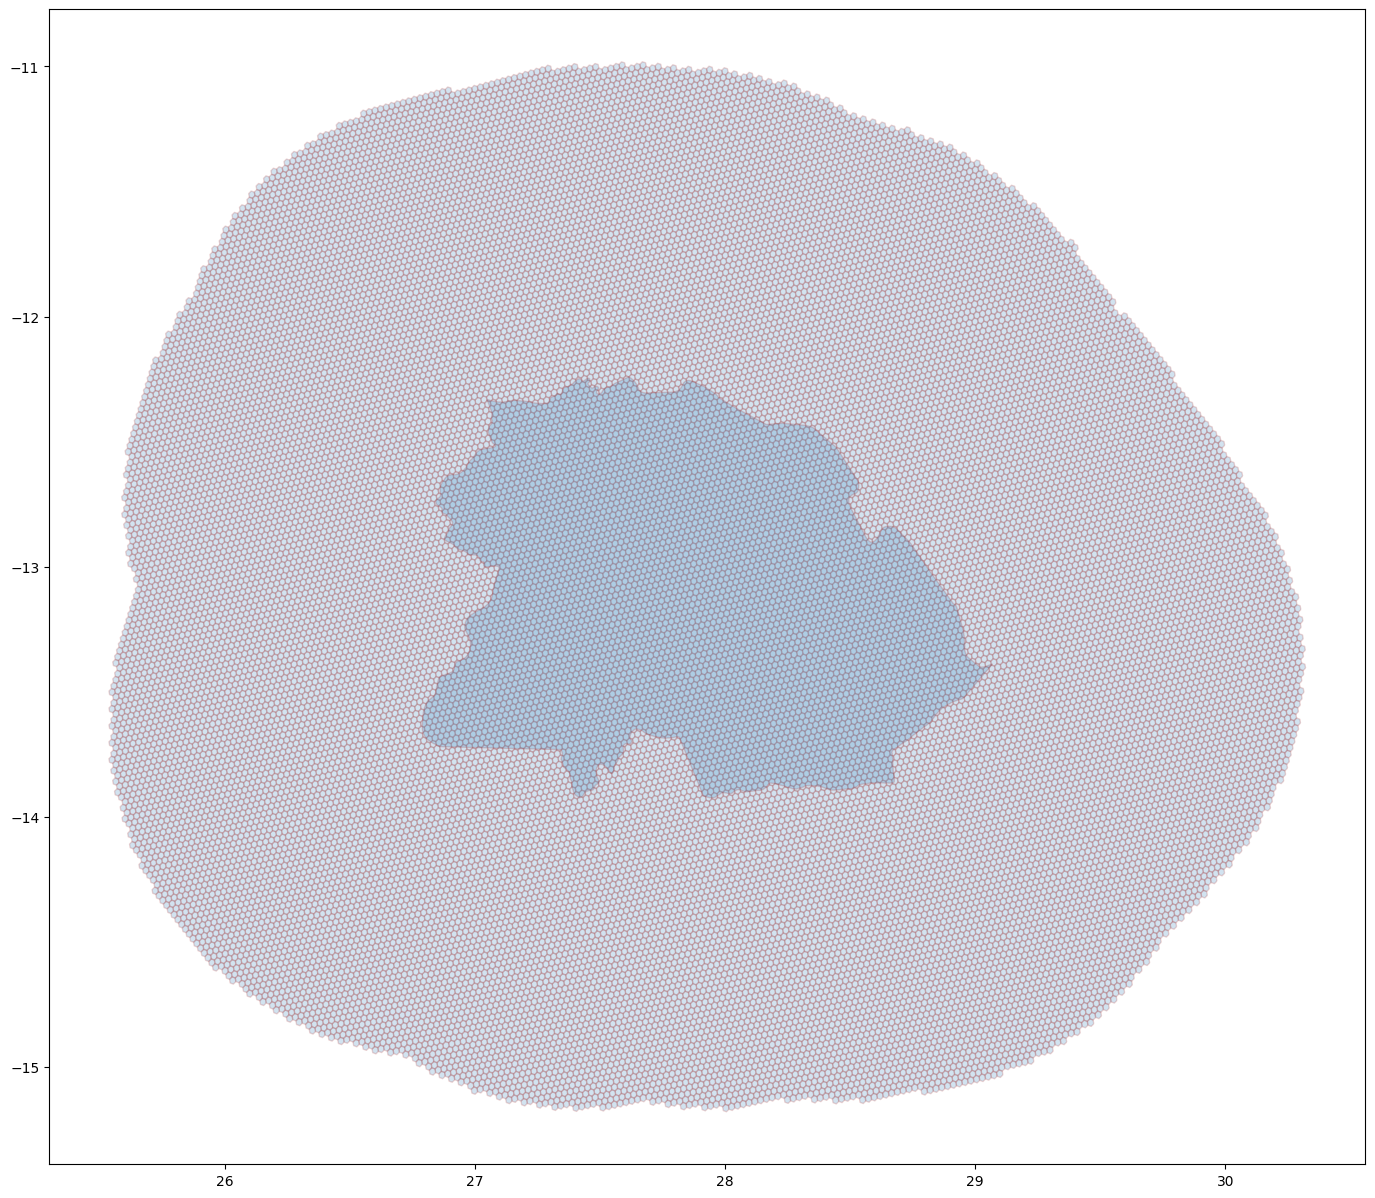

In [15]:
# Plot fishnet & basemap
fig, ax = plt.subplots(figsize=(25, 15))
hexagons.plot(ax=ax, edgecolor='brown', alpha=0.2)
admin_gdf.plot(ax=ax, edgecolor='brown', alpha=0.2)
ax.set_aspect('equal', 'box')

# Save plot as figure 
#plt.savefig('admin level basemap.png', bbox_inches='tight')

In [16]:
#Clipping to the borders of the admin area
join_left_df = gpd.sjoin(hexagons, admin_gdf[[adm_col_name, "geometry"]], how="left")
hexagons = join_left_df[join_left_df[adm_col_name].notnull()]

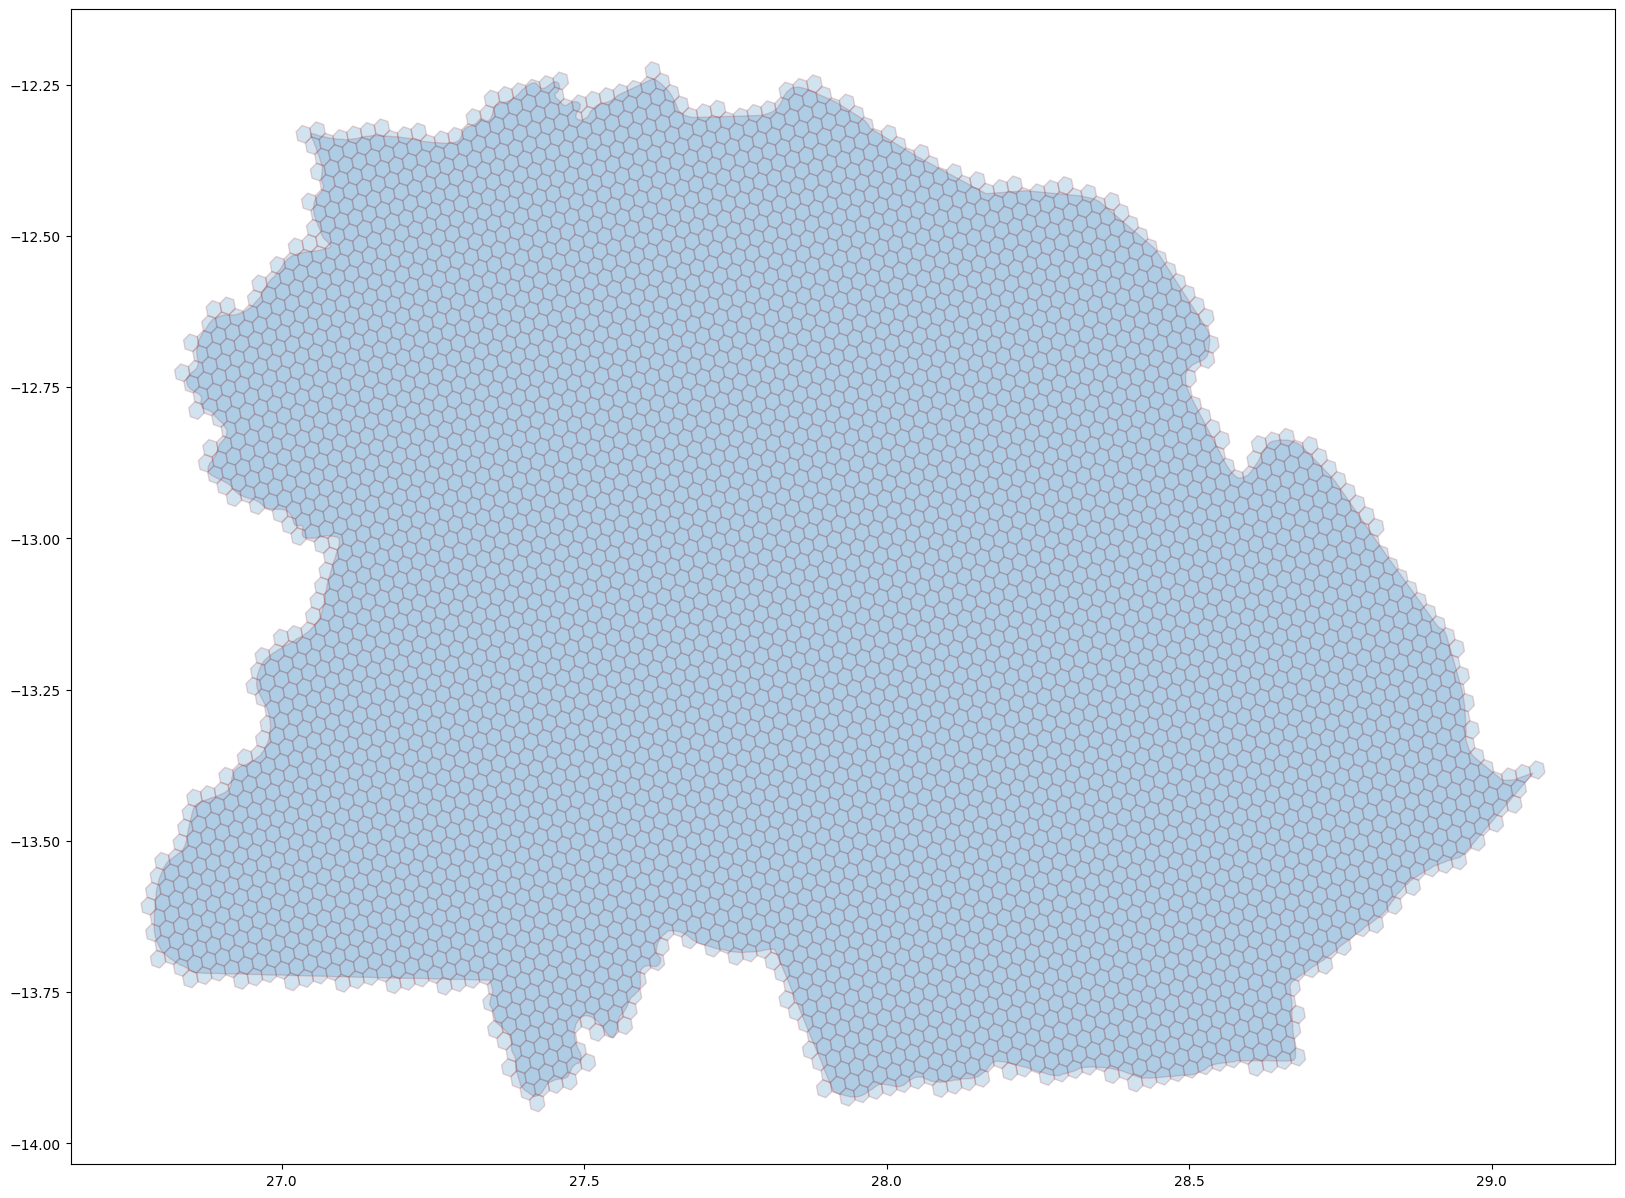

In [17]:
# Plot fishnet & basemap
fig, ax = plt.subplots(figsize=(25, 15))
hexagons.plot(ax=ax, edgecolor='brown', alpha=0.2)
admin_gdf.plot(ax=ax, edgecolor='brown', alpha=0.2)
ax.set_aspect('equal', 'box')

# Save plot as figure 
#plt.savefig('admin level basemap.png', bbox_inches='tight')

#### Select base map grid

In [19]:
# grid = hexagons

In [20]:
hexagons['id'] = range(1, len(hexagons)+1)

In [21]:
hexagons.head(3)

,hexagons,geometry,lon,lat,index_right,ADM1_NAME,id
4,8755343b5ffffff,"POLYGON ((27.69305 -12.65074, 27.68300 -12.661...",27.6803,-12.6464,0.0000,COPPERBELT,1
5,875530d90ffffff,"POLYGON ((27.26518 -13.44960, 27.25506 -13.459...",27.2524,-13.4451,0.0000,COPPERBELT,2
14,8755340cdffffff,"POLYGON ((27.69388 -12.71964, 27.68383 -12.729...",27.6811,-12.7152,0.0000,COPPERBELT,3


In [18]:
# Export dataframe to csv or gpkg
#hexagons.to_csv(out_path + "\\" + f'h3_grid_at_hex_{size}.csv', index=False)
hexagons.to_file(out_path + "\\" + f'h3_grid_at_hex_{size}.shp', index=False)
# with fiona.Env(OSR_WKT_FORMAT="WKT2_2018"):
#     hexagons.to_file(out_path + "\\" + f'h3_grid_at_hex_{size}.shp', index=False, engine='fiona')
# hexagons.to_file(out_path + "\\" + f'h3_grid_at_hex_{size}.shp', index=False, engine='pyogrio')